# Using Markov Chain Monte Carlo method for project estimation #

One type of criticism I received for the [previous work on project estimation](agile_estimation_2.ipynb) is that the log-Normal distribution has short tails. And this is true, despite all the benefits of log-Normal distribution. The reason is very simple: when fitting the data to the distribution shape we pick the most likely parameters $\mu$ and $\sigma$. This approach, however easy it is, always results in short tails, especially for the small amount of data we possess. Indeed, the parameters of the log-normal distribution can be different, than the most likely parameters we've got based on five data points. The appropriate way would be to get the joint distribution of the predictions and parameters and then marginalize by the parameters. In case of the Normal distribution we would get Student's t-distribution with nice long tails. For the log-normal distribution we would get a more complex distribution, but also with long tails.

To remind you the problem we are working on, our task is to estimate the number of story points that can fit into one Agile iteration/sprint based on the historic data. In particular, we are interested in finding the number of story points we can complete in one iteration with 95% confidence.

We will start by defining the likelihood function for the sample of size one:
$$ p(x | \mu,\sigma^2) = \frac{1}{x \sigma \sqrt{2 \pi}} e^{-\frac{(\ln x - \mu)^2}{2 \sigma^2}}$$



Let's select the priors for $\mu$ and $\sigma$.

For $\sigma$ we  choose non-informative prior:

$$\rho(\sigma^2) \propto \frac{1}{\sigma}$$

For $\mu$ we choose the conjugate prior which is a Normal distribution with a L2 regularization  hyperparameter $\lambda$:

$$\rho(\mu|\lambda) \propto e^{-\frac{\lambda \mu^2}{2 }}$$



The posterior probability in this case is proportional to:

$$p(\mu, \sigma^2 | x^{(i)}) \propto \frac{1}{\sigma^{N+1}} e^{-\frac{\lambda \mu^2}{2 \sigma^2}} 
\prod_i e^{-\frac{(\ln x^{(i)} - \mu)^2}{2 \sigma^2}}$$

The joint probability distribution, that will let us calculate percentiles, is therefore:
$$p(x, \mu, \sigma^2 | x^{(i)}) = p(x | \mu, \sigma) p(\mu, \sigma^2 | x^{(i)}) 
\propto \frac{1}{\sigma^{N+2}} e^{-\frac{\lambda \mu^2}{2}} 
e^{-\frac{(\ln x - \mu)^2}{2 \sigma^2}}
\prod_i e^{-\frac{(\ln x^{(i)} - \mu)^2}{2 \sigma^2}} $$


So we can calculate all percentiles by marginalizing over the parameters $\mu$ and $\sigma$. 
The answer can be derived analytically, but in our case I want to solve it numerically using MCMC Hamiltonian sampling method. 

The idea of this method is to get a sample of joined distribution $p(x, \mu, \sigma^2 | x^{(i)})$. After that we can calculate percentiles of $x$. This equivalent to marginalizing by the parameters. 

As I said earlier, the answer can be derived analytically, but we will use a method that can be used for the distributions, for which it is hard or impossible to get a sample. This method is called [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). The idea of this method is to do a random walk in the variable space, but try to visit more probable areas more frequently, so that in the resulting sample the histogram follows the probability distribution. Some of the unlikely values in this case have to be rejected. 

A specific flavor of MCMC is the Hamiltonian sampling method. It is somewhat similar to the Gradient Descent algorithm, except that instead of trying to converge to the minimum of the cost function, the step in MCMC is large enough, so that it explores also the less likely regions in the variable space, but tends to visit in the high probable regions more often.

For this we need to take a log of the joint distribution function (ignoring the constant):

$$ \mathscr{L} = -(N+2)\ln \sigma -\frac{\lambda \mu^2}{2} -\frac{(\ln x - \mu)^2}{2 \sigma^2} - \sum_i \frac{(\ln x^{(i)} - \mu)^2}{2 \sigma^2} $$

There are many libraries to do Hamiltonian sampling. There are even probabilistic programming languages optimized for this, for example, Stan. But here we will use TensorFlow Probability, a probabilistic library created by Google

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

C:\Users\michael\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lamb = 2e-1
def log_likelihood(x, mu, sigma2):
    'The (negative) log likelihood function for one sample'
    return (tf.log(x)-mu)**2/2.0/sigma2

In [3]:
def get_unnormalized_log_probability(data):
    def joined_probability(x, mu, sigma2):
        result = -(2.0+len(data))/2*tf.log(sigma2) - lamb * mu**2/2.0 -log_likelihood(x, mu, sigma2) #sigma2
        for datum in data:
            result -= log_likelihood(float(datum), mu, sigma2)
        return result
    return joined_probability

We want to make sure our functions are working correctly, and the best way to do that is to write a unit test

In [4]:
import unittest
import math

class TestUnnormalizedLogProbability(unittest.TestCase):

    def test_get(self):
        tf.reset_default_graph()
        data=np.array([1.0,1.0])
        x = tf.constant(value=1.0)
        mu = tf.constant(value=0.0)
        sigma2 = tf.exp(1.0)
        probability_function = get_unnormalized_log_probability(data)
        probability = probability_function(x, mu, sigma2)
        
        init = tf.global_variables_initializer()

        with tf.Session() as sess:
            sess.run(init)
            self.assertTrue(abs(-2-probability.eval())<1e-5)
        


unittest.main(argv=[''], verbosity=0, exit=False);

----------------------------------------------------------------------
Ran 1 test in 0.088s

OK


We will use the same data as we used earlier

In [5]:
data=np.array([14, 12,  7, 14, 13])
# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=1e-1,
    use_resource=True,  # For TFE compatibility.
    trainable=False)

In [6]:
# Initialize the HMC transition kernel.
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=get_unnormalized_log_probability(data),
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
    seed=1398)

# Run the chain (with burn-in).
samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=int(1e5),
    #num_burnin_steps=int(1e1),
    current_state=[10.0,2.0,0.2],
    kernel=hmc)

In [7]:
# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    init_op.run()
    samples_, kernel_results_ = sess.run([samples, kernel_results])

In [8]:
all_samples = np.array(samples_)
all_samples.shape

(3, 100000)

Our results has three rows for $x$, $\mu$ and $\sigma$ respectively. We can take mean of these three variables

In [9]:
all_samples.mean(axis=1)

array([14.040146  ,  2.4572225 ,  0.21323058], dtype=float32)

Unexpectedly, the mean of `x` is higher than we thought it would be (12). Let's plot the histogram to see the probability distribution:

C:\Users\michael\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\michael\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\michael\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\michael\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\michael\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=Tr

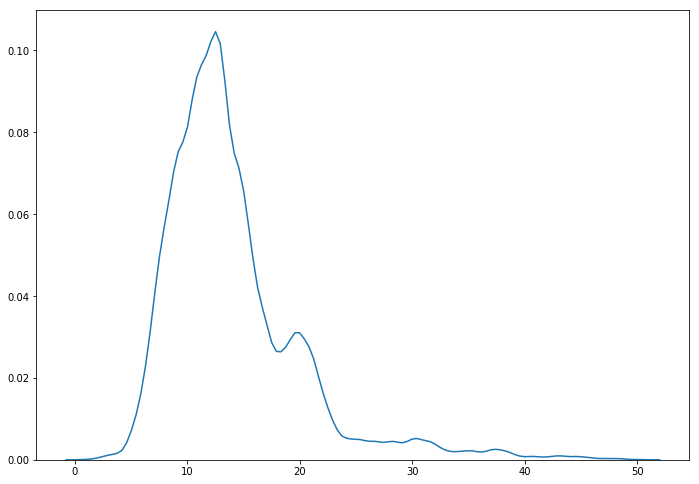

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.distplot(all_samples[0,:], hist=False);

We see that the maximum is around 12, as we would get using maximum posterior distribution. 

The curve has an irregular shape, but that is somewhat expected for multivariate MCMC results. Notice also, that the tails are longer that we would get for log-Normal distribution. This is the result of marginalizing over the parameters of the posterior distribution. Let's see what our 95% confidence would fall into:

In [11]:
np.percentile(all_samples[0,:], q=5)
 

7.160015678405762

The 95% confidence is also remarkably close to what we've got in a simpler approach. However experimenting with the MCMC I discovered that the method is unstable and depends strongly on seeding, initial values and the choice of hyperparameters. The problem is aggravated as the dimensionality increases. 

## Conclusion ##
In this notebook we tried to use Bayesian approach in Agile project estimation, and, instead of calculating the percentiles analytically, we demonstrated how we can use Markov chain Monte Carlo and Hamiltonian sampling to achieve this result. We also demonstrated how we can do it in TensorFlow Probability package.